In [1]:
%matplotlib notebook

import random

import numpy as np

from environment import Easy21Environment, Easy21State

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Monte-Carlo Agent

In [39]:
class MonteCarloAgent():
    def __init__( self ):
        # Params
        self.n_0 = 100000
        self.total_episodes = 2 ** 16

        # Globals
        self.env = Easy21Environment()

        # Vars
        self.visits = self.emptyStateActionSpace()
        self.q_estimate = self.emptyStateActionSpace()
        self.actions = self.env.getActionSpace()

    def combineStateAction( self, state, action ):
        return tuple( list( state ) + [ action ] )
        
    def emptyStateActionSpace( self ):
        state_action_space = self.combineStateAction( self.env.getStateSpace(), self.env.getActionSpace() )
        return np.zeros( state_action_space )
        
    def getStateVisits( self, state ):
        """
        Sum over actions for state
        """
        return np.sum( self.visits[ tuple( state ) ] )

    def getEpsilon( self, state ):
        state_visits = self.getStateVisits( state )
        return self.n_0 / ( self.n_0 + state_visits )

    def epsilonGreedy( self, state, should_print=False ):
        """
        Uses epsilon greedy policy to select an action
        epsilon = n_0 / ( n_0 + N( s ) )
        if random > epsilon:
            act greedy (select action with highest estimated reward)
        else:
            act random
        """
        epsilon = self.getEpsilon( state )
        if( random.random() > epsilon ): # Act greedy 
            return self.q_estimate[ tuple( state ) ].argmax()
        else:
            if should_print:
                print( epsilon )
                print( "Exploring" )
            return random.randint( 0, self.actions-1 )

    def getStep( self, state ):
        return 1 / self.visits[ tuple( state ) ]

    def train( self ):
        training_total_wins = 0
        for i in range( self.total_episodes ):
            # Run Episode
            state = Easy21State()
            used_state_actions = []
            total_reward = 0
            while not state.terminal:
                action = self.epsilonGreedy( state.state() )
                used_state_actions.append( np.append( state.state(), action ) )
                state, reward = self.env.step( state, action )
                total_reward += reward

            if total_reward == 1:
                training_total_wins += 1

            # Learn
            for used_state_action in used_state_actions:
                self.visits[ tuple( used_state_action ) ] += 1
                estimate = self.q_estimate[ tuple( used_state_action ) ]
                error = total_reward - estimate
                step = self.getStep( used_state_action )
                """
                step_size = 1 / N( s, a )
                """
                new_estimate = estimate + error * step
                self.q_estimate[ tuple( used_state_action ) ] = new_estimate
                """
                Q(s,a) = Q(s, a) + ( ( step_size ) * ( actual_reward - Q( s, a ) ) )
                """

        return training_total_wins / self.total_episodes

In [110]:
mca = MonteCarloAgent()

mca.n_0 = 100
mca.total_episodes = 50000

for i in range( 10 ):
    mca.train()

<IPython.core.display.Javascript object>


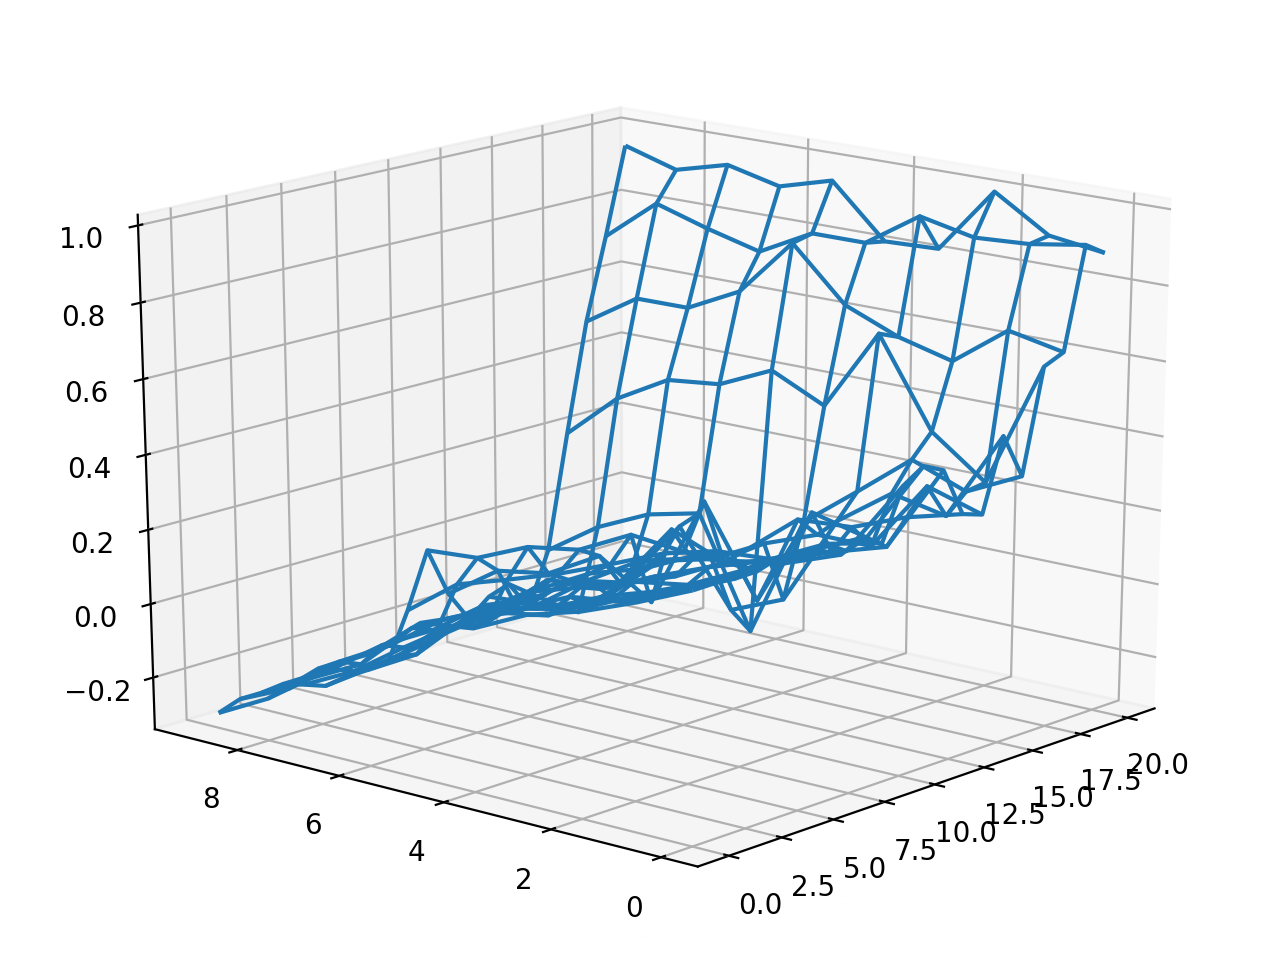

<IPython.core.display.Javascript object>


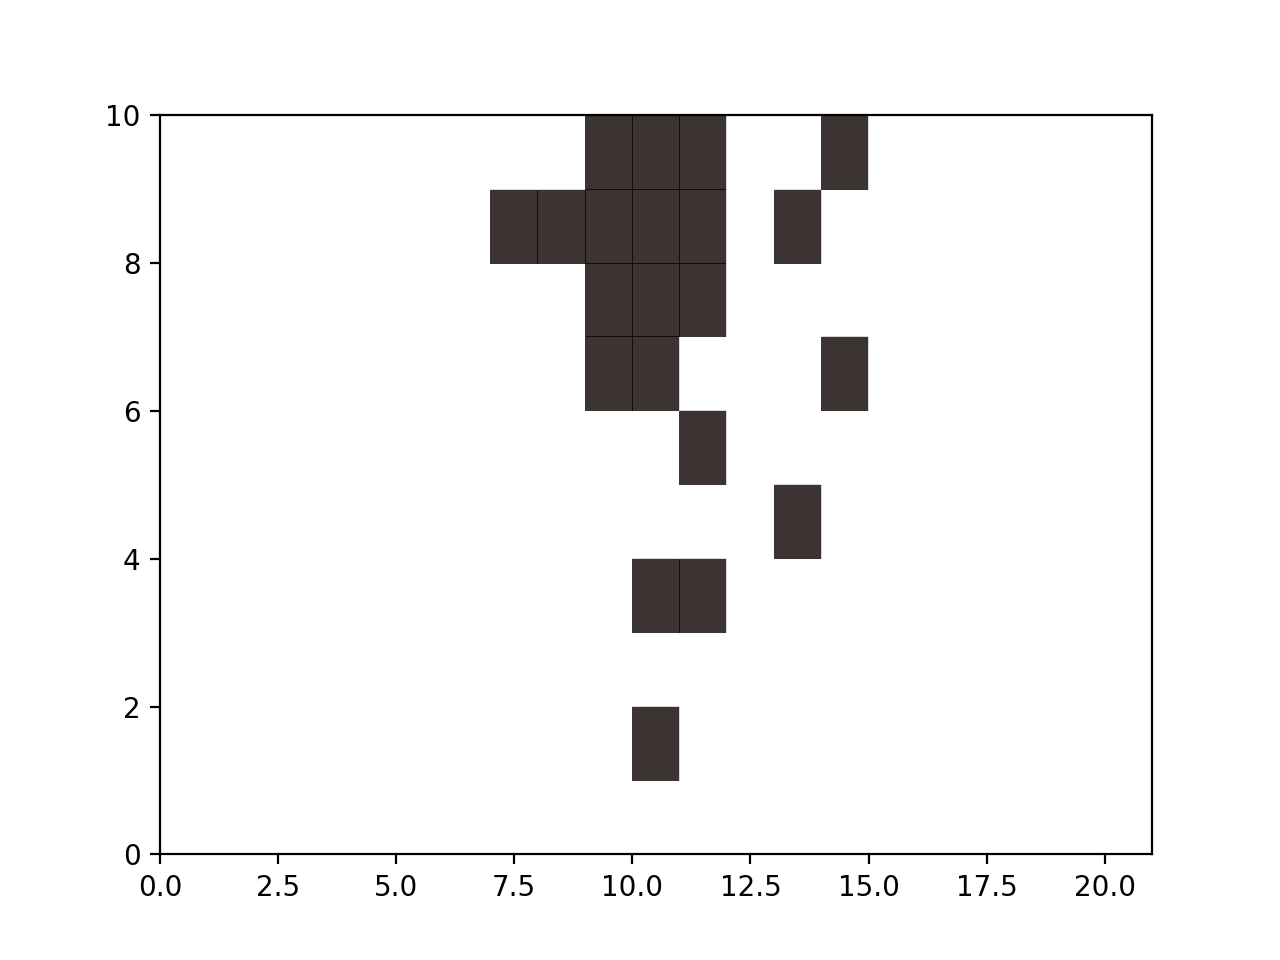

<IPython.core.display.Javascript object>


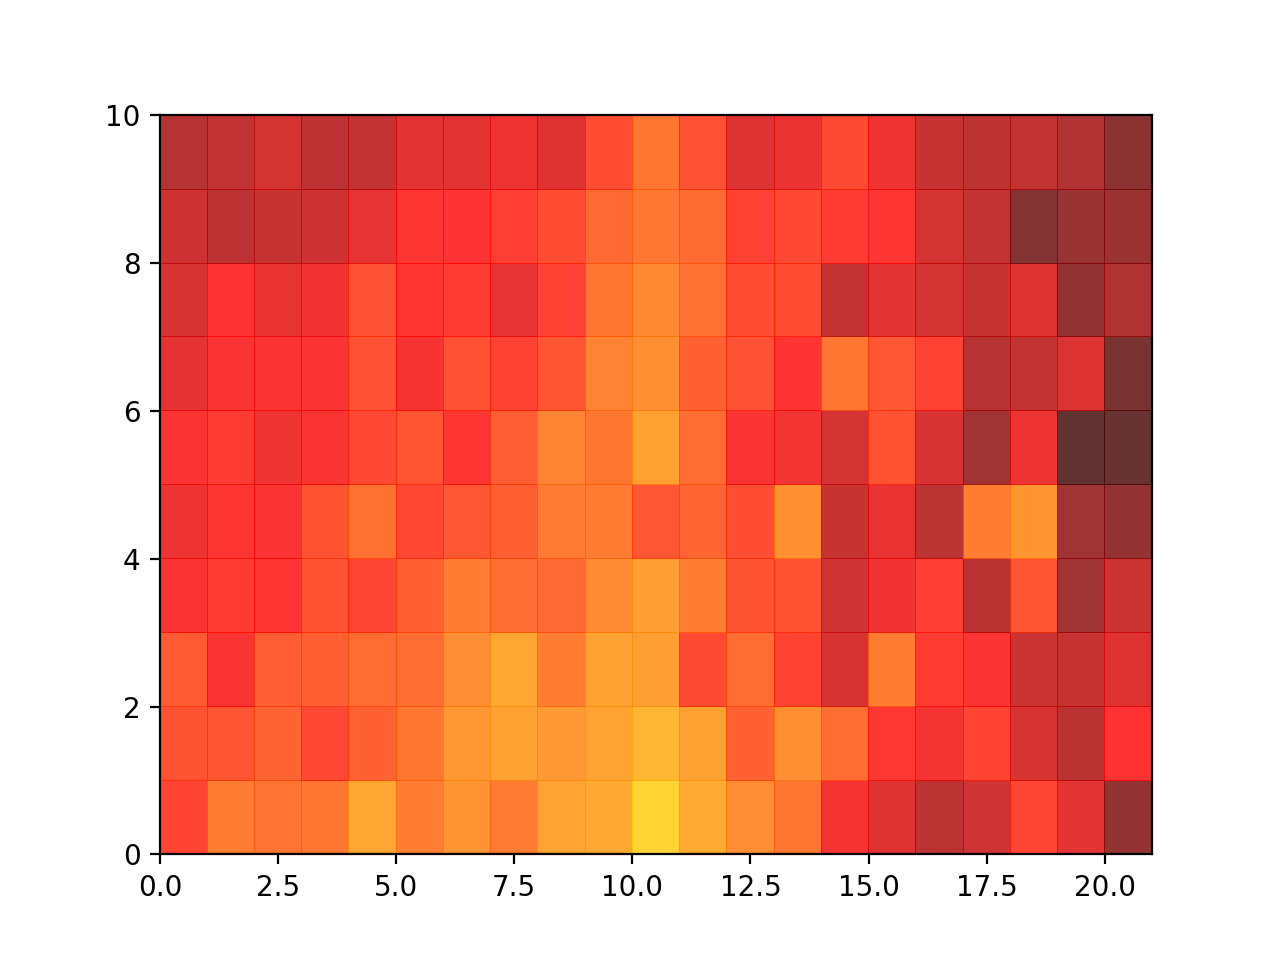

<IPython.core.display.Javascript object>


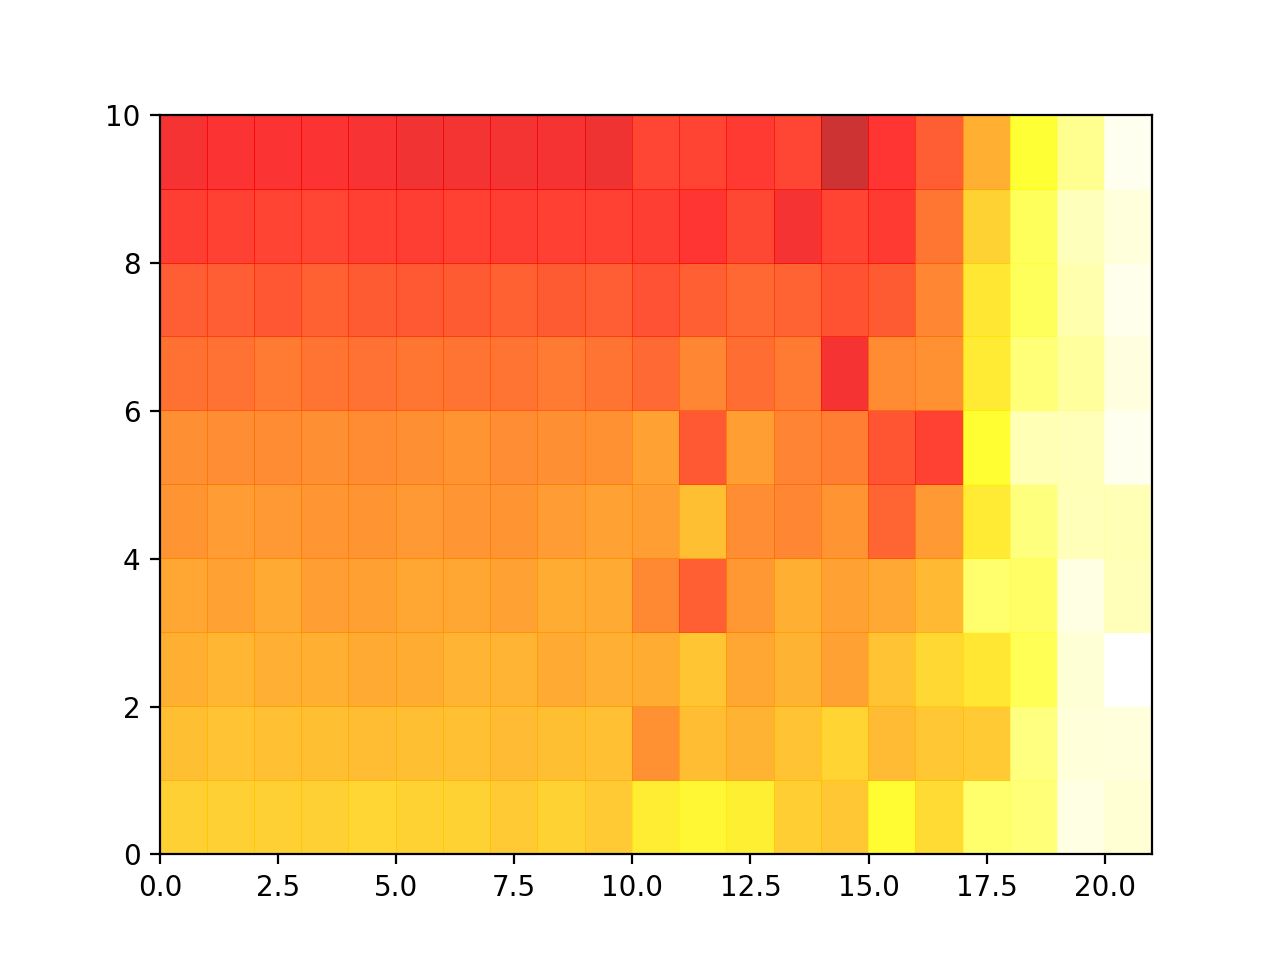

In [152]:
def plot( z ):
    x = range( z.shape[ 1 ] )
    y = range( z.shape[ 0 ] )
    X, Y = np.meshgrid( x, y )
    
    fig = plt.figure()
    ax = Axes3D( fig )
    ax.plot_wireframe( X, Y, z )

plot( np.max( mca.q_estimate, axis=2 ) )

fig, ax = plt.subplots()
ax.pcolor(np.argmax( mca.q_estimate, axis=2 ), cmap=plt.cm.hot, alpha=0.8)
fig, ax = plt.subplots()
ax.pcolor(mca.q_estimate[:, :, 0], cmap=plt.cm.hot, alpha=0.8, vmin=-1, vmax=1)
fig, ax = plt.subplots()
ax.pcolor(mca.q_estimate[:, :, 1], cmap=plt.cm.hot, alpha=0.8, vmin=-1, vmax=1)

## Sansa(Lambda)



In [137]:
class SansaLambdaAgent(MonteCarloAgent):
    """
    Agent for Sansa(Lambda)
    We are using the same exploration schedule / step size
    so we just inherit those methods from MonteCarlo
    """
    def __init__( self ):
        super().__init__()
        self.train_lambda = 0.1

    def train( self ):
        for i in range( self.total_episodes ):
            eligability_traces = self.emptyStateActionSpace()

            state = Easy21State()
            last_action = self.epsilonGreedy( state.state() )
            while not state.terminal:
                next_state, reward = self.env.step( state, last_action )

                state_action = self.combineStateAction( state.state(), last_action )
                self.visits[ state_action ] += 1
                eligability_traces[ state_action ] += 1

                estimated_future_reward = 0
                next_action = None

                # There is no future reward if the next_state is terminal
                if not next_state.terminal:
                    next_action = self.epsilonGreedy( next_state.state() )
                    next_state_action = self.combineStateAction( next_state.state(), next_action )
                    estimated_future_reward = self.q_estimate[ next_state_action ]

                estimated_reward = self.q_estimate[ state_action ]
                error = reward + estimated_future_reward - estimated_reward

                for position, eligibility in np.ndenumerate( eligability_traces ):
                    if eligibility == 0.0:
                        continue
                    step = self.getStep( position )
                    self.q_estimate[ position ] += eligibility * step * error
                    eligability_traces[ position ] *= self.train_lambda
                
                state = next_state
                last_action = next_action

def trainForLambda( train_lambda ):
    sla = SansaLambdaAgent()
    sla.total_episodes = 1000
    sla.train_lambda = train_lambda
    sla.train()

    mean_squared_error = np.sum( ( sla.q_estimate - mca.q_estimate ) ** 2 )
    print( train_lambda, mean_squared_error )

for i in np.linspace( 0, 1, 11 ):
    trainForLambda( i )

0.0 107.94688401208072
0.1 97.99038126602433
0.2 109.28133341750097
0.30000000000000004 104.67718999832788
0.4 111.24726218304454
0.5 113.55146586148564
0.6000000000000001 103.09846510050446
0.7000000000000001 103.8267645077313
0.8 118.41985025201755
0.9 118.1535148052636
1.0 140.10114089284315


<IPython.core.display.Javascript object>


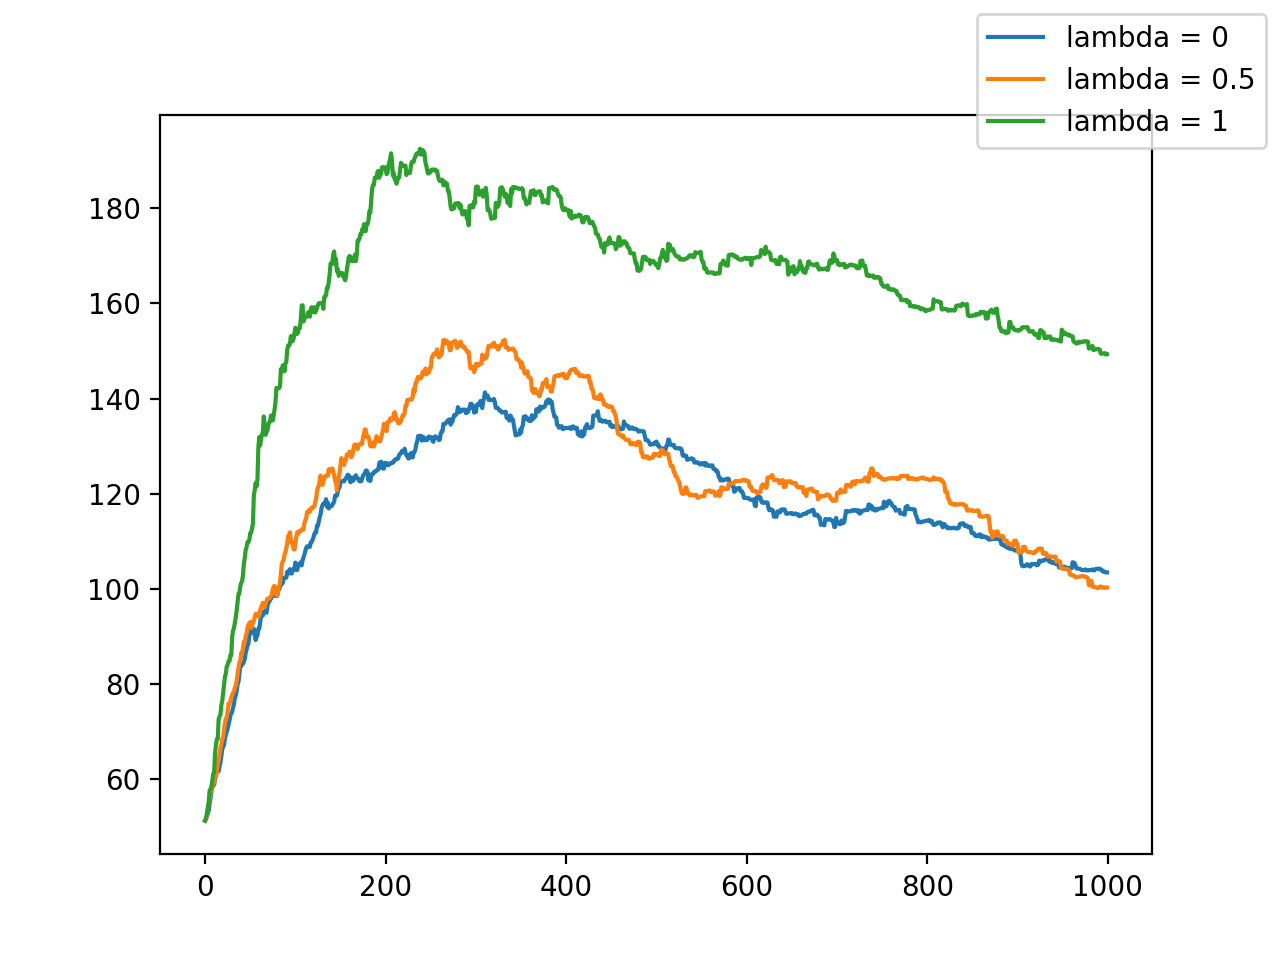

In [151]:
sla = SansaLambdaAgent()
sla.total_episodes = 1
sla.train_lambda = 0
mean_squared_errors = []
for i in range( 1000 ):
    sla.train()
    mean_squared_error = np.sum( ( sla.q_estimate - mca.q_estimate ) ** 2 )
    mean_squared_errors.append( mean_squared_error )
fig = plt.figure()
plt.plot( mean_squared_errors, label="lambda = 0" )

sla = SansaLambdaAgent()
sla.total_episodes = 1
sla.train_lambda = 0.5
mean_squared_errors = []
for i in range( 1000 ):
    sla.train()
    mean_squared_error = np.sum( ( sla.q_estimate - mca.q_estimate ) ** 2 )
    mean_squared_errors.append( mean_squared_error )
ax = plt.plot( mean_squared_errors, label="lambda = 0.5" )

sla = SansaLambdaAgent()
sla.total_episodes = 1
sla.train_lambda = 1
mean_squared_errors = []
for i in range( 1000 ):
    sla.train()
    mean_squared_error = np.sum( ( sla.q_estimate - mca.q_estimate ) ** 2 )
    mean_squared_errors.append( mean_squared_error )
ax = plt.plot( mean_squared_errors, label="lambda = 1" )
fig.legend()